#Input of pickled metabolomics time series data and curve-fitting each compound
##This time around, the amplitude and offset are defined by the dataset, and only the t50 and width are parameters for curve fitting

In [2]:
# http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp
# from scipy.optimize import fmin_slsqp
import numpy as np
import pickle
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import pandas as pd
import math
%matplotlib inline



###After importing all the necessary packages, load the pickled `data` dictionary

In [3]:
with open('onur_data.pkl','r') as f:
    data = pickle.load(f)

###Now that the `data` dictionary is loaded, create a function that returns the input to the modeled equation, and another function that returns the residual, *i.e.* the error

In [4]:
def my_func(t,a,o,p):
    '''
    From, Time-Resolved Metabolic Footprinting for Nonlinear Modeling of Bacterial Substrate Utilization
    Behrends, Ebbels, Wiliams, and Bundy
    
    Input
    t: a 1d numpy array representing time points that were sampled
    a: the amplitude between the starting point and the lowest level a metabolite goes to
    o: the offset, which is the final amplitude
    p: the parameters in the model below
    
    Output:
    y: a 1d numpy array representing the magnitude of a given metabolite over time
    
    Model:
    y = a / (1 + np.exp( (t - p[0]) / p[1])) + o
    
    where:
    p[0] is the t_50 or t one-half, which is the time at half-amplitude
    p[1] is the width or time of the exponent to go from 1 to -1

    Authors:
    Ben Bowen and Onur Erbilgin
    2015, December 3
    JGI, Berkeley Lab
    
    '''
    return a / (1 + np.exp( (t - p[0]) / p[1] ) ) + o

# depricated.  this only used for fmin_slsqp
# def my_residual(a,t,y):
#     return np.sum((y-my_func(t,a))**2)

def my_residual(p,t,y,a,o):
    for i in p:
        if i < 0:
            return y + 1e20
    return y-my_func(t,a,o,p)

* **`my_func`** is the equation based off of a published paper: Behrends *et. al.* 2009:
$$y=\frac{amplitude}{1+e^{-\frac{x-t_{50}}{width}}}+offset$$ 
  * The equation and manuscript actually contained two errors:
    1. The sign on the exponent of *e* was incorrect
    2. The definition of 'offset' was incorrect: the offset is actually the difference between the final concentration and 0, or simply the final amplitude
  * So after fixing the equation and replacing the variables with what we used, it becomes:
$$ \frac{a}{1+e^{\frac{t-p[0]}{p[1]}}}+o$$
  * t50 and offset are represented by items in the list **`p`** just for simplicity - they could have also been individual variables.


* The **`my_residual`** function is necessary because that's what curve fitting scripts use to refine their paramter "wiggling" while fitting the data.
  * The depricated **`my_residual`** function was used for out initial curve-fitter (which turned out to be bad); each curve fitter might require a different input of residual
    * What this function returned was the square of the difference between the observed and calculated y
  * The current curve-fitter we use sums the squares of the residual automatically, so we didn't need to do that in our own residual function
  * The **`for`** loop returns an enormous error if any of the parameters are zero. This is necessary to bound the space of what the parameters can be (none of them can be zero!)
    * I think you can similarly give all parameters a second bound (*e.g.* **`if i < 0 or i >100`**) or individual parameters their own bound(s):
```
    def my_residual(p, t, y, a, o):
        if p[0] > 10 or p[1] < 0 or p[0=1] >100:
            return y + 1e20
        return y-my_func(t,a,o,p)
```
  * Otherwise, if the parameters are within our bounds, then the function returns the difference between observed and calculated y

###To make sure that we entered everything correctly, we now test out our curve fitter on some mock data
(Doing this test is how we discovered the above errors)
1. Make some fake data, give it some noise
2. Use the curve fitter to model the noisy data
3. See how well the fitter did

t50:       12.0742388964 	 True t50:    12
Width:     1.00476814412 	 True Width:  1


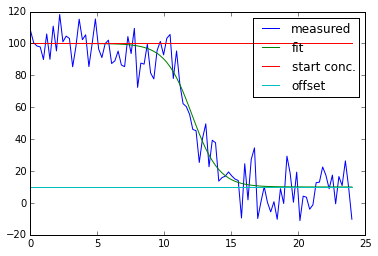

In [5]:

N = 100 #the number of time points
t_max = 24 #max time of experiment

t=np.linspace(0,t_max,N)
#some values to create fake data
o = 10 #offset aka finishing concentration
m = 100 #starting concentration
a = m - o #amplitude
o = 10 #offset
p_create_fake_data = [
    12, #t_50
    1] #width

y_measured =my_func(t,a,o,p_create_fake_data) + np.random.normal(0,10,N)
#give the fitter an initial guess
p_guess = [
    10, #t_50
    2] #width


out = leastsq(my_residual,p_guess,args=(t,y_measured,a,o))

y_fit = my_func(t,a,o,out[0])
print 't50:      ', out[0][0], '\t True t50:   ', p_create_fake_data[0]
print 'Width:    ', out[0][1], '\t True Width: ', p_create_fake_data[1]

plt.plot(t,y_measured, label='measured')
plt.plot(t,y_fit, label='fit')
plt.plot([np.amin(t),np.amax(t)], [a+o,a+o], label='start conc.')
plt.plot([np.amin(t),np.amax(t)], [o,o], label='offset')
plt.legend()
plt.show()

* The first few lines in this block are to set up the `t` variable
  * **`np.linspace`** creates an array of evenly spaced numbers across an interval; in this case 100 even timepoints across 24 hours
* With **`a_create_fake_data`** we make a list of parameters for our equation to spit out some perfect data (*i.e.* use the equation to give us our mock y values)
  * We then use this list to enter parameters into **`my_func`**, which will spit out our perfect data, then add noise to the output using **`np.random.normal`**, which draws a random number from a gaussian distribution around the first argument (mean: 0), defined by the width (standard deviation: 10), and the size (which should be the number of samples/timepoints
    * What's happening in the code is that since the parameter **`t`** is an array of timepoints, so they all enter the equation in parallel and what is spit out is an array of y values
* For the curve fitter to work, you need to give it an initial guess, which we do with **`a_guess`**
* **`leastsq`** is a function in `scipy` where the first argument calls a residual function, the second argument is the initial estimate of the parameters to "wiggle," which also must be the first argument for the residual function, and the third argument of **`leastsq`** is a list of the remaining arguments for the residual function
  * To simplify downstream, we define the output of the curve fitter to an array (**`out`**)
  * The first element in the array (index 0) is a list of the parameters that the curvefitter fit for the equation we gave it
* We then use this output to make an array of **`y_fit`** values, to draw the fitted curve
* And finally we display the results of the curve fitter, comparing them to our input values. Seems to match up well!

###Now that we know the curve fitter works, we can put in our real data and get some real parameters and plots
1. Pull out the relevant data from the **`data`** dictionary
2. Add some new arrays to the dictionary to hold **`fit_results`**, **`fit_residual`**, and **`y_fit`** values
  1. **`fit_results`** and **`fit_residual`** need to be # strain-replicates x # compounds, and these will store the respective results and residual for each compound for each strain-replicate; **`fit_results`** needs to have an additional dimension to store each of the fit parameters (4)?
  2. **`y_fit`** needs to be the same size as the concentration matrix (**`M`**), as this will store the 
3. Iterate through the compounds for each strain-replicate and copy the concentration data for that compound across the timecourse from the matrix
4. Run the curve fitter on that compound
5. Aggregate the plots and print them as a figure

In [6]:
#this is to troubleshoot 9B05C dataset
'''
for iii in range(len(data['dim1'])):
    print 'Looking into', data['dim1'][iii]
    print '************'
    for i in range(len(data['dim2'])):
        print data['dim2'][i], ':'
        print data['M'][iii][i][:]
        print '------------'
'''
#Discovered that the curve fitting problems were due to empty data being valued at 0, especially for 9B05C, where t0 is 0.
#Now need to fill in the 0 data with something so that the curve fitter doesn't get thrown off

for j in range(len(data['dim2'])):
    data['M'][5][j][0] = data['M'][5][j][1]
'''
print data['dim1'][5]
print data['dim2']
print data['dim3'][0]
for i in range(len(data['dim2'])):
    print data['dim2'][i], ':'
    print data['M'][5][i][:]
'''

"\nprint data['dim1'][5]\nprint data['dim2']\nprint data['dim3'][0]\nfor i in range(len(data['dim2'])):\n    print data['dim2'][i], ':'\n    print data['M'][5][i][:]\n"

In [7]:
t = np.asarray(data['dim3'])
data['fit_result'] = np.zeros((len(data['dim1']),len(data['dim2']),2))
data['fit_residual'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['y_fit'] = np.zeros(data['M'].shape)
for iii in range(len(data['dim1'])):
    for i in range(len(data['dim2'])):
        y_measured = data['M'][iii,i,:].flatten()
        o= np.amin(y_measured) #set offset to lowest concentration found in the time series
        a=(y_measured[0] + np.amax(y_measured))/2 - o #starting amp is in between the max concentration and t0, minus the lowest concentration in the time series
        p_guess = np.asarray([
            4, #t_50
            1]) #width
        # out, fx, its, imode, smode = fmin_slsqp(my_residual,a_guess,args=(t,y_measured),bounds=[(0,1e9),(0.0001,None),(0.0001,26),(0,1e9)], full_output=True)
        out = leastsq(my_residual,p_guess,args=(t,y_measured,a,o))
        y_fit = my_func(t,a,o,out[0])
        data['y_fit'][iii,i,:] = y_fit
        data['fit_result'][iii,i,:] = out[0]
        data['fit_residual'][iii,i] = out[1]
        # print out
        plt.subplot(4,5,i)
        plt.plot(t,y_measured,'.', label='measured')
        plt.plot(t,y_fit, label='fit')
        plt.plot([np.amin(t),np.amax(t)], [a+o,a+o], label='start conc.')
        plt.plot([np.amin(t),np.amax(t)], [o,o], label='offset')
        plt.text(12,a-a/4,'t50: %s \n w: %s' %(out[0][0],out[0][1]))
        plt.title(data['dim2'][i].replace(' Results Final Conc.',''))
    #     plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.tight_layout()
    fig.savefig('%snew2.png'%data['dim1'][iii], dpi=100)
    fig.clear()
#plt.show()

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


* The first line makes an array containing each timepoint
* Within the for loop, **`iii`** is the index for the strain-replicate (dim1), and **`i`** is the index for the compounds (dim2)
  * Using these two indexes, we go into the concentration matrix and pull out an array containing the concentrations at all the timepoints (this is why the colon is used - slices that entire dimension out)
  * The guess, **`out`**, and **`y_fit`** are all the same as the test-run
  * The next set of lines puts in the data points for **`y_fit`** (the fitted curve), each parameter for **`fit_result`**, and stores the **`fit_residual`**
    * The last two are separated pieces from the output of the curve fitter
  * The final set of lines in the inner loop store the plot for that compound (remember: designated by index **`i`**) for each strain-replicate as a subplot within a larger plot for that particular strain-replicate (remember: designated by index **`iii`**)
    * **`plt.subplot(x,y,z)`**: `x` and `y` define the dimensions of the plot, and `z` indicates which of the subplots you are about to plot using **`plt.plot`**
  * And the final set of lines in the outer loop create a figure from the plot of subplots, naming the file as the strain-replicate (**`iii`**)
  
##Now it's time to incorporate the growth curve data (optical density)
1. Import growth curve data
2. Clean it up for later data analysis
3. Make the plot!

In [8]:
od = pd.read_csv('../../Data/AAG_timecourses/20151014_3B10_9B05_L13_timecourse.csv')
od

,Unnamed: 0,3B10,Unnamed: 2,Unnamed: 3,9B05,Unnamed: 5,Unnamed: 6,L13,Unnamed: 8,Unnamed: 9
0,hours,A,B,C,A,B,C,A,B,C
1,0,0.011853846,0.013053846,0.015253846,0.015653846,0.015953846,0.017253846,0.016953846,0.017253846,0.018053846
2,2,0.049253846,0.034753846,0.039353846,0.031653846,0.029653846,0.023253846,0.014753846,0.014153846,0.017553846
3,3,0.107053846,0.094853846,0.097653846,0.061053846,0.060953846,0.056653846,0.039953846,0.041353846,0.042053846
4,4,0.209053846,0.209553846,0.209553846,0.167553846,0.168853846,0.156853846,0.108053846,0.102453846,0.110353846
5,5,0.393653846,0.397553846,0.394353846,0.280853846,0.293353846,0.291653846,0.188853846,0.187953846,0.190153846
6,6,0.548953846,0.544353846,0.533053846,0.448853846,0.446353846,0.450953846,0.343353846,0.338253846,0.343753846
7,7,0.728269231,0.656769231,0.621769231,0.590269231,0.573269231,0.557769231,0.389769231,0.418769231,0.415769231
8,8,0.859269231,0.823269231,0.833269231,0.793269231,0.775769231,0.759769231,0.627269231,0.614769231,0.636769231
9,9,0.829269231,0.761269231,0.826269231,0.771769231,0.758269231,0.727769231,0.625269231,0.622769231,0.657769231


###Clean up the table
1. Re-name the columns
2. Re-name the rows to correspond to the timepoint hour

In [9]:
new_headers = []
header = ''
for i in od.keys():
    if not 'Unnamed' in i:
        header = i
    new_headers.append('%s %s'%(header, od.ix[0,i]))
    #print new_headers
od.columns = new_headers #rename the header (columns)
od = od.drop(0) #drop the now useless first row
od = od.astype(float) #change the data types to floats
od.index = od[' hours']
del od[' hours']
od

,3B10 A,3B10 B,3B10 C,9B05 A,9B05 B,9B05 C,L13 A,L13 B,L13 C
hours,,,,,,,,,
0,0.011854,0.013054,0.015254,0.015654,0.015954,0.017254,0.016954,0.017254,0.018054
2,0.049254,0.034754,0.039354,0.031654,0.029654,0.023254,0.014754,0.014154,0.017554
3,0.107054,0.094854,0.097654,0.061054,0.060954,0.056654,0.039954,0.041354,0.042054
4,0.209054,0.209554,0.209554,0.167554,0.168854,0.156854,0.108054,0.102454,0.110354
5,0.393654,0.397554,0.394354,0.280854,0.293354,0.291654,0.188854,0.187954,0.190154
6,0.548954,0.544354,0.533054,0.448854,0.446354,0.450954,0.343354,0.338254,0.343754
7,0.728269,0.656769,0.621769,0.590269,0.573269,0.557769,0.389769,0.418769,0.415769
8,0.859269,0.823269,0.833269,0.793269,0.775769,0.759769,0.627269,0.614769,0.636769
9,0.829269,0.761269,0.826269,0.771769,0.758269,0.727769,0.625269,0.622769,0.657769


###Now we need to annotate the optical density plot based on the t50 and width
1. Add a symbol at the t50 point, on the OD plot
2. Add a horizontal line onto that symbol, corresponding to the width


* First thing to set up is a nice color scheme for each compound
  * There are 20 compounds, so make a list of 20 colors in ROYGBIV order!

In [10]:
colors=[
    'darkred',
    'red',
    'palevioletred',
    'violet',
    'magenta',
    'saddlebrown',
    'coral',
    'orange',
    'gold',
    'greenyellow',
    'darkkhaki',
    'lime',
    'green',
    'olivedrab',
    'darkcyan',
    'mediumaquamarine',
    'blue',
    'steelblue',
    'purple',
    'indigo',
]
#for i,j in enumerate(colors):
#    plt.plot([0,5],[i+1,i+1], color = j, label = j)
#    plt.legend()

1. The first problem we will run into for plotting the t50 onto the OD plot is that the t50 does not correspond exactly with one of the timepoints for the OD, so we will need to estimate at what OD that t50 actually corresponds to
  1. The easiest (brute force) way to do this is to model a simple line (y=mx+b) between the datapoint before and after the t50, and use that to calculate what the OD should be 
    1. Round the calcluated t50 down and up to the nearest hour to find the matching timepoint
    2. Use the OD measurements from those timepoints to solve the equation for a straight line between those points
    3. Use that equation to calculate the OD that corresponds to the t50, and there you have your x,y coordinates
  2. The more elegant but longer way is to use a curve fitter to fit the raw OD data to a neat line, and use that equation to calculate what the coordinates should be for t50
2. The second problem we will run into is that the timepoints were not taken every hour: there is no t1 timepoint, and there are no timepoints between t12 and t26
3. After solving those problems, make a figure depicting this awesome data

In [11]:
#data['fit_result'][dim1][dim2][k=0] contains the t50 (k=0) for each compound (dim2) for each strain-isolate (dim1)
#dim1=1

for dim1,d1 in enumerate(data['fit_result']):
    plt.subplot(3,4,dim1+1)
    plt.plot(od.index, od[data['dim1'][dim1]], color = 'black', label = data['dim1'][0])
    for dim2,d2 in enumerate(data['fit_result'][0]):
        w = data['fit_result'][dim1][dim2][1]
        t50 = data['fit_result'][dim1][dim2][0]
        t50_low = math.floor(data['fit_result'][dim1][dim2][0])
        t50_high = math.ceil(data['fit_result'][dim1][dim2][0])
        #conditional statements needed in case the t50 is in between t12 and t26 timepoints - would otherwise give crazy value
        if t50_high <= 12:
            for i, j in enumerate(od.index):
                if j == t50_low:
                    idx_low = i
                if j == t50_high:
                    idx_high = i
            x1=od.index[idx_low]
            y1=od.iloc[idx_low,dim1]
            x2=od.index[idx_high]
            y2=od.iloc[idx_high,dim1]
        else:
            x1=od.index[-2]
            y1=od.iloc[-2,dim1]
            x2=od.index[-1]
            y2=od.iloc[-1,dim1]
        m = (y2 - y1)/(x2 - x1)
        b = y1 - m * x1
        t50_od = m * t50 + b
        plt.plot([t50-w,t50+w],[t50_od,t50_od], color = colors[dim2], linewidth = 2)
        plt.plot(t50,t50_od, marker ='s', color = colors[dim2], label = data['dim2'][dim2].replace('Results Final Conc.',''))
        plt.title(data['dim1'][dim1])
        #plt.legend()

#this plot is for the legend of the figure; what color corresponds to which compound        
plt.subplot(3,4,dim1+2)
for i,j in enumerate(colors):
    plt.plot(1,i*1.5,marker='s',color = j)
    plt.text(1.2,(i*1.5)-0.4,'%s'%(data['dim2'][i].replace('Results Final Conc.','')))
plt.ylim([-1,30])
plt.xlim([0,10])

fig2 = plt.gcf()
fig2.set_size_inches(18.5, 10.5)
plt.tight_layout()
fig2.savefig('Behrends.png', dpi=100)
fig2.clear()

* The way we dealt with t50's between 12 and 26 hours is a conditional if statement:
  * If the t50 is less than or equal to 12, then that's fine proceed as planned
  * If it's not (so greater than 12 hours), then use the second to last (12 hour) and last (26 hour) timepoints to calculate the equation
    * Note that this will probably need to be changed depending on the time course
* While pandas has an internal way to use matplotlib to visualize data in the dataframe, I found that you have more control over the plots by just extracting data from the dataframe and plotting it

###Plot the replicate growth curves of each strain
But we want to overlay the growth curves of the same strain on top of each other, to get a visual representation of variation

1. Only overlay OD plots of the same strain
2. Overlay the t50 and width data onto the plots

In [12]:
strains = [
    '3B10',
    '9B05',
    'L13'
]
for n,strain in enumerate(strains):
    for dim1,d1 in enumerate(data['fit_result']):
        if strain in data['dim1'][dim1]:
            plt.subplot(2,2,n+1)
            plt.plot(od.index, od[data['dim1'][dim1]], color = 'black', label = data['dim1'][0])
            for dim2,d2 in enumerate(data['fit_result'][0]):
                w = data['fit_result'][dim1][dim2][1]
                t50 = data['fit_result'][dim1][dim2][0]
                t50_low = math.floor(data['fit_result'][dim1][dim2][0])
                t50_high = math.ceil(data['fit_result'][dim1][dim2][0])
                #conditional statements needed in case the t50 is in between t12 and t26 timepoints - would otherwise give crazy value
                if t50_high <= 12:
                    for i, j in enumerate(od.index):
                        if j == t50_low:
                            idx_low = i
                        if j == t50_high:
                            idx_high = i
                    x1=od.index[idx_low]
                    y1=od.iloc[idx_low,dim1]
                    x2=od.index[idx_high]
                    y2=od.iloc[idx_high,dim1]
                else:
                    x1=od.index[-2]
                    y1=od.iloc[-2,dim1]
                    x2=od.index[-1]
                    y2=od.iloc[-1,dim1]
                m = (y2 - y1)/(x2 - x1)
                b = y1 - m * x1
                t50_od = m * t50 + b
                plt.plot([t50-w,t50+w],[t50_od,t50_od], color = colors[dim2], linewidth = 2)
                plt.plot(t50,t50_od, marker ='s', color = colors[dim2], label = data['dim2'][dim2].replace('Results Final Conc.',''))
                plt.title(data['dim1'][dim1].replace('C','')) #would need to change the .replace to whatever the last replicate's code is
                plt.xlim([0,26])
                plt.ylim([0,1])
                #plt.legend()

#this plot is for the legend of the figure; what color corresponds to which compound        
plt.subplot(2,2,n+2)
for i,j in enumerate(colors):
    plt.plot(1,i*1.5,marker='s',color = j)
    plt.text(1.2,(i*1.5)-0.4,'%s'%(data['dim2'][i].replace('Results Final Conc.','')))
plt.ylim([-1,30])
plt.xlim([0,10])

fig3 = plt.gcf()
fig3.set_size_inches(18.5, 10.5)
plt.tight_layout()
fig3.savefig('Behrends_overlaid.png', dpi=100)
fig3.clear()

In [13]:
#average the data
columns = data['dim1']
index = []
reps = 3

for i in data['dim2']:
    index.append(i)
    
t50s = pd.DataFrame(columns = columns, index=index).astype(float)
wids = pd.DataFrame(columns = columns, index = index).astype(float)

for r,replicate in enumerate(data['dim1']):
    for c,compound in enumerate(data['dim2']):
        t50s[replicate][compound] = data['fit_result'][r,c,0]
        wids[replicate][compound] = data['fit_result'][r,c,1]
writer = pd.ExcelWriter('Data.xlsx', engine='xlsxwriter')
t50s.to_excel(writer, 't50s', header = True, index = True)
wids.to_excel(writer, 'widths', header = True, index = True)
writer.save()

t50df = t50s.groupby(lambda x: x.split(' ')[0], axis = 1).mean()
widdf = wids.groupby(lambda x: x.split(' ')[0], axis = 1).mean()
odavg = od.groupby(lambda x: x.split(' ')[0], axis =1).mean()

In [14]:
for s,strain in enumerate(odavg.columns):
    plt.subplot(2,2,s+1)
    plt.plot(odavg.index, odavg[strain], color = 'black', label = odavg.columns[0])
    for c,comp in enumerate(t50df.index):
        w = widdf.iloc[c,s]
        t50 = t50df.iloc[c,s]
        t50_low = math.floor(t50)
        t50_high = math.ceil(t50)
        #conditional statements needed in case the t50 is in between t12 and t26 timepoints - would otherwise give crazy value
        if t50_high <= 12:
            for i, j in enumerate(odavg.index):
                if j == t50_low:
                    idx_low = i
                if j == t50_high:
                    idx_high = i
            x1=odavg.index[idx_low]
            y1=odavg.iloc[idx_low,s]
            x2=odavg.index[idx_high]
            y2=odavg.iloc[idx_high,s]
        else:
            x1=odavg.index[-2]
            y1=odavg.iloc[-2,s]
            x2=odavg.index[-1]
            y2=odavg.iloc[-1,s]
        m = (y2 - y1)/(x2 - x1)
        b = y1 - m * x1
        t50_od = m * t50 + b
        plt.plot([t50-w,t50+w],[t50_od,t50_od], color = colors[c], linewidth = 2)
        plt.plot(t50,t50_od, marker ='s', color = colors[c], label = t50df.index[c].replace('Results Final Conc.',''))
        plt.title(odavg.columns[s])
        #plt.legend()

#this plot is for the legend of the figure; what color corresponds to which compound        
plt.subplot(2,2,s+2)
for i,j in enumerate(colors):
    plt.plot(1,i*1.5,marker='s',color = j)
    plt.text(1.2,(i*1.5)-0.4,'%s'%(data['dim2'][i].replace('Results Final Conc.','')))
plt.ylim([-1,30])
plt.xlim([0,10])

fig3 = plt.gcf()
fig3.set_size_inches(18.5, 10.5)
plt.tight_layout()
fig3.savefig('Behrends_avg.png', dpi=100)
fig3.clear()

In [18]:
group1 = [
    'glutamine ',
    'glutamate ',
    'asparagine ',
    'aspartate ',
    'serine ',
    'methionine ',
    'threonine '
]
group2 = [
    'leucine ',
    'isoleucine ',
    'valine ',
    'glycine ',
    'alanine ',
    'proline ',
    'glucose '
]
group3 = [
    'arginine ',
    'lysine ',
    'histidine ',
    'tyrosine ',
    'phenylalanine ',
    'tryptophan '
]

#this should make the number of plots 
groups = 3
strains = len(odavg.columns)
count = 1
for s,strain in enumerate(odavg.columns):
    for i in range(groups):
        plt.subplot(strains,groups,count)
        plt.plot(odavg.index, odavg[strain], color = 'black', label = odavg.columns[0])
        plt.title(strain)
        count = count + 1

for s,strain in enumerate(odavg.columns):
    for c,comp in enumerate(t50df.index):
        w = widdf.iloc[c,s]
        t50 = t50df.iloc[c,s]
        t50_low = math.floor(t50)
        t50_high = math.ceil(t50)
        #conditional statements needed in case the t50 is in between t12 and t26 timepoints - would otherwise give crazy value
        if t50_high <= 12:
            for i, j in enumerate(odavg.index):
                if j == t50_low:
                    idx_low = i
                if j == t50_high:
                    idx_high = i
            x1=odavg.index[idx_low]
            y1=odavg.iloc[idx_low,s]
            x2=odavg.index[idx_high]
            y2=odavg.iloc[idx_high,s]
        else:
            x1=odavg.index[-2]
            y1=odavg.iloc[-2,s]
            x2=odavg.index[-1]
            y2=odavg.iloc[-1,s]
        m = (y2 - y1)/(x2 - x1)
        b = y1 - m * x1
        t50_od = m * t50 + b
        if comp.replace('Results Final Conc.','') in group1:
            plt.subplot(strains,groups,(s*groups)+1)
            plt.plot([t50-w,t50+w],[t50_od,t50_od], color = colors[c], linewidth = 2, label = comp)
            plt.plot(t50,t50_od, marker ='s', color = colors[c], label = t50df.index[c].replace('Results Final Conc.',''))   
            for q, cmpd in enumerate(group1):
                if t50df.index[c].replace('Results Final Conc.','') == cmpd:
                    plt.plot(8,0.05+q*0.05, marker='s', color=colors[c])
                    plt.text(8.2,0.025+q*0.05,'%s'%(cmpd))
        elif comp.replace('Results Final Conc.','') in group2:
            plt.subplot(strains,groups,(s*groups)+2)
            plt.plot([t50-w,t50+w],[t50_od,t50_od], color = colors[c], linewidth = 2, label = comp)
            plt.plot(t50,t50_od, marker ='s', color = colors[c], label = t50df.index[c].replace('Results Final Conc.',''))
            plt.title(odavg.columns[s])
            for qq, cmpd in enumerate(group2):
                if t50df.index[c].replace('Results Final Conc.','') == cmpd:
                    plt.plot(8,0.05+qq*0.05, marker='s', color=colors[c])
                    plt.text(8.2,0.025+qq*0.05,'%s'%(cmpd))
        elif comp.replace('Results Final Conc.','') in group3:
            plt.subplot(strains,groups,(s*groups)+3)
            plt.plot([t50-w,t50+w],[t50_od,t50_od], color = colors[c], linewidth = 2, label = comp)
            plt.plot(t50,t50_od, marker ='s', color = colors[c], label = t50df.index[c].replace('Results Final Conc.',''))
            plt.title(odavg.columns[s])
            for qqq, cmpd in enumerate(group3):
                if t50df.index[c].replace('Results Final Conc.','') == cmpd:
                    plt.plot(8,0.05+qqq*0.05, marker='s', color=colors[c])
                    plt.text(8.2,0.025+qqq*0.05,'%s'%(cmpd))
        else:
            print 'error'
        plt.xlim(0,12)
        #plt.legend()

fig3 = plt.gcf()
fig3.set_size_inches(18.5, 10.5)
plt.tight_layout()
fig3.savefig('Behrends_avg_groups.png', dpi=100)
fig3.clear()


###Now dump the data dictionary into a file so you have all the data generated saved

In [12]:
with open("onur_data_including_fit.pkl",'w') as f:
    pickle.dump(data,f)

#At the end of all this, you will now have:
###1. A .png file for each strain-replicate, which has a plot showing the actual data points in blue, and the fitted curve in green
###2. A dictionary key populated with values of the parameters that the curve fitter spit out

#There are still many ways to make this better
* The `amplitude` and `offset` parameters are actually defined by the data; we just need to code that in
* We can find a better curve-fitter
* Instead of saving the fit results as a "naked" list, we can store them in a way where when we export the information, it will be in a neat table that labels which value is what (t50 vs width) and organizes it neatly (columns are strain-replicates (subcolumns are t50 and width), and rows are compounds
  * Probably easiest to do this in pandas?